This is an example from langgraph, Adding image graph to understand the flow 

In [11]:
from utils.helper import get_open_ai_model_and_key
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

from langgraph.constants import Send
from langgraph.graph import END, StateGraph

# Model and prompts
# Define model and prompts we will use
#subjects_prompt = """Generate a comma separated list of between 2 and 5 {topic}."""
# joke_prompt = """Generate a joke about {subject}"""
# best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

# {jokes}"""


class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class BestJoke(BaseModel):
    id: int


In [12]:

key, model = get_open_ai_model_and_key()
model = ChatOpenAI(api_key=key, model=model)

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    subjects_prompt = """Generate a comma separated list of between 2 and 5 {topic}."""
    prompt = subjects_prompt.format(topic=state["topic"])
    #"""Generate a comma separated list of between 2 and 5 {topic}."""
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    joke_prompt = """Generate a joke about {subject}"""
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".format()
    best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.
    {jokes}"""
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


In [13]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.set_entry_point("generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes)
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

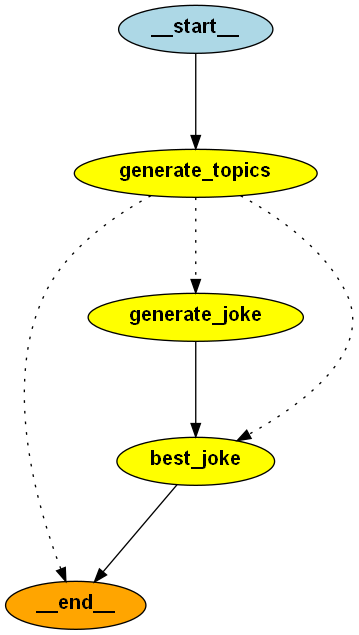

In [14]:
from IPython.display import Image
Image(app.get_graph().draw_png())

In [15]:

# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['cat', 'dog', 'elephant', 'lion', 'monkey']}}
{'generate_joke': {'jokes': ['Why did the elephant bring a suitcase to the beach? Because it was planning to stay for a trunk show!']}}
{'generate_joke': {'jokes': ['Why was the cat sitting on the computer? Because it wanted to keep an eye on the mouse!']}}
{'generate_joke': {'jokes': ['Why did the lion eat the tightrope walker? He wanted a well-balanced meal!']}}
{'generate_joke': {'jokes': ["Why did the dog sit in the shade? Because he didn't want to be a hot dog!"]}}
{'generate_joke': {'jokes': ["Why don't monkeys use smartphones? Because they prefer bananas for their daily dose of potassium!"]}}
{'best_joke': {'best_selected_joke': 'Why was the cat sitting on the computer? Because it wanted to keep an eye on the mouse!'}}
